# HW2 Yongjin Kim

Note that for several initial settings, I directly copy from our lecture material.

In [1]:
import pandas as pd
import numpy as np
import requests

The Coinbase-pro exchange did not offer FLOW coins. Plus there were not many exchanges providing the FLOW-USD pair (though there were for stable dollar-pegged coins such as FLOW-USDT etc). Therefore, for the FLOW-USD pair in particular, I scraped it from the Kraken exchange.

In [2]:
def get_data(token):
    exchange = 'kraken' if token == 'FLOW' else 'coinbase-pro'
        
    res = requests.get(
        f'https://api.cryptowat.ch/markets/{exchange}/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )

    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df


In [3]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']

In [4]:
df_base = pd.concat(get_data(token) for token in tokens)
df_base

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH
...,...,...,...,...,...,...,...,...
514,2021-12-13 10:00:00,9.015,9.016,8.981,9.012,743.007828,6.683477e+03,FLOW
515,2021-12-13 11:00:00,9.020,9.021,8.994,9.018,10437.544130,9.403413e+04,FLOW
516,2021-12-13 12:00:00,9.017,9.127,9.000,9.124,26130.079295,2.365591e+05,FLOW
517,2021-12-13 13:00:00,9.126,9.299,9.123,9.130,36156.486241,3.323358e+05,FLOW


Since the `volumeUSD`(and `volume`) values for the above refer to hourly data, the "total" USD volume traded for each coin would require us to sum up for the given period from `2021-11-22 00:00:00` up to today. I use the `groupby(*)` function to accomplish this.

In [5]:
df = df_base.set_index('ts')
df.head()

,open,high,low,close,volume,volumeUSD,token
ts,,,,,,,
2021-11-22 00:00:00,4317.98,4342.24,4246.07,4262.99,7262.562789,3.123077e+07,ETH
2021-11-22 01:00:00,4263.04,4270.34,4212.45,4234.37,8437.946084,3.574586e+07,ETH
2021-11-22 02:00:00,4234.87,4246.72,4171.17,4217.89,9259.725370,3.895639e+07,ETH
2021-11-22 03:00:00,4217.88,4223.48,4163.58,4193.47,9259.899519,3.882032e+07,ETH
2021-11-22 04:00:00,4192.95,4213.59,4147.00,4168.35,7934.546906,3.315476e+07,ETH


The sorted values in a descending manner are shown as below

In [6]:
df.groupby('token')['volumeUSD'].sum().to_frame().sort_values('volumeUSD', ascending = False)

,volumeUSD
token,
ETH,1.994199e+10
SOL,6.536670e+09
AVAX,3.310260e+09
USDT,1.909839e+09
FLOW,8.346712e+07


Now I add a column that calculates the close price ratio between ETH and SOL for each house. First I derive the wanted column.

In [7]:
df_eth_sol = pd.merge(
    df.loc[df['token']=='ETH']['close'].rename(f'close_ETH'),
    df.loc[df['token']=='SOL']['close'].rename(f'close_SOL'),
    left_index= True,
    right_index=True
)

df_eth_sol['close_ETH/SOL'] = df_eth_sol['close_ETH']/df_eth_sol['close_SOL']
df_eth_sol

,close_ETH,close_SOL,close_ETH/SOL
ts,,,
2021-11-22 00:00:00,4262.99,230.785,18.471694
2021-11-22 01:00:00,4234.37,226.000,18.736150
2021-11-22 02:00:00,4217.89,227.037,18.577985
2021-11-22 03:00:00,4193.47,223.117,18.794937
2021-11-22 04:00:00,4168.35,220.652,18.891059
...,...,...,...
2021-12-13 10:00:00,4001.58,166.030,24.101548
2021-12-13 11:00:00,3997.43,166.540,24.002822
2021-12-13 12:00:00,4014.21,167.840,23.916885


Below, I show the result of merging the wanted column to the originally provided data. Note that for the given `ts` value, the `close_ETH/SOL` values are the same.

In [8]:
df = df.join(df_eth_sol['close_ETH/SOL'])
df

,open,high,low,close,volume,volumeUSD,token,close_ETH/SOL
ts,,,,,,,,
2021-11-22 00:00:00,4317.9800,4342.2400,4246.0700,4262.9900,7.262563e+03,3.123077e+07,ETH,18.471694
2021-11-22 00:00:00,230.4830,234.6880,228.8050,230.7850,9.353180e+04,2.172284e+07,SOL,18.471694
2021-11-22 00:00:00,131.6900,133.7900,127.7000,128.6700,9.686748e+04,1.267080e+07,AVAX,18.471694
2021-11-22 00:00:00,1.0010,1.0017,1.0009,1.0012,9.987681e+06,9.999090e+06,USDT,18.471694
2021-11-22 00:00:00,13.8870,14.1690,13.8870,14.1500,2.326138e+04,3.274755e+05,FLOW,18.471694
...,...,...,...,...,...,...,...,...
2021-12-13 14:00:00,3990.3500,3998.1800,3961.1900,3978.6600,1.068802e+04,4.256376e+07,ETH,24.102865
2021-12-13 14:00:00,166.5800,167.3600,164.4500,165.0700,4.551686e+04,7.533289e+06,SOL,24.102865
2021-12-13 14:00:00,83.6400,83.8800,82.2500,83.7500,4.934888e+04,4.097087e+06,AVAX,24.102865


Now changing the column names as instructed.

In [9]:
df.rename(columns = {'volume':'volumeBase', 'volumeUSD':'volumeTerm'}, inplace = True)
df

,open,high,low,close,volumeBase,volumeTerm,token,close_ETH/SOL
ts,,,,,,,,
2021-11-22 00:00:00,4317.9800,4342.2400,4246.0700,4262.9900,7.262563e+03,3.123077e+07,ETH,18.471694
2021-11-22 00:00:00,230.4830,234.6880,228.8050,230.7850,9.353180e+04,2.172284e+07,SOL,18.471694
2021-11-22 00:00:00,131.6900,133.7900,127.7000,128.6700,9.686748e+04,1.267080e+07,AVAX,18.471694
2021-11-22 00:00:00,1.0010,1.0017,1.0009,1.0012,9.987681e+06,9.999090e+06,USDT,18.471694
2021-11-22 00:00:00,13.8870,14.1690,13.8870,14.1500,2.326138e+04,3.274755e+05,FLOW,18.471694
...,...,...,...,...,...,...,...,...
2021-12-13 14:00:00,3990.3500,3998.1800,3961.1900,3978.6600,1.068802e+04,4.256376e+07,ETH,24.102865
2021-12-13 14:00:00,166.5800,167.3600,164.4500,165.0700,4.551686e+04,7.533289e+06,SOL,24.102865
2021-12-13 14:00:00,83.6400,83.8800,82.2500,83.7500,4.934888e+04,4.097087e+06,AVAX,24.102865


Now creating a fat table indexed by the time stamp with each column as the close price of each token. 

## Note!!
 The HW2 instructions hints that the derived table ought to have 200 rows. However the table I derived had 515 rows(or possibly more if you run this file at some later date). I believe this discrepancy is due to the fact that the instructor (Yang) created this HW2 several days before when the total number of timestamps starting from 2021-11-22 was around 200. 

In [10]:
df_pivoted = df.reset_index().pivot(index='ts',columns='token',values='close')
df_pivoted

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,128.67,4262.99,14.150,230.785,1.0012
2021-11-22 01:00:00,134.85,4234.37,13.621,226.000,1.0013
2021-11-22 02:00:00,132.54,4217.89,13.753,227.037,1.0012
2021-11-22 03:00:00,133.38,4193.47,13.652,223.117,1.0011
2021-11-22 04:00:00,136.29,4168.35,13.581,220.652,1.0009
...,...,...,...,...,...
2021-12-13 10:00:00,84.97,4001.58,9.012,166.030,1.0005
2021-12-13 11:00:00,84.33,3997.43,9.018,166.540,1.0006
2021-12-13 12:00:00,84.48,4014.21,9.124,167.840,1.0004


Now I calculate the hour by hour log return of the close price of each token

In [11]:
tokens = df_pivoted.columns

for col in tokens:
    df_pivoted[f'{col}_past_hour'] = df_pivoted[col].shift(periods=1)

df_pivoted

token,AVAX,ETH,FLOW,SOL,USDT,AVAX_past_hour,ETH_past_hour,FLOW_past_hour,SOL_past_hour,USDT_past_hour
ts,,,,,,,,,,
2021-11-22 00:00:00,128.67,4262.99,14.150,230.785,1.0012,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,134.85,4234.37,13.621,226.000,1.0013,128.67,4262.99,14.150,230.785,1.0012
2021-11-22 02:00:00,132.54,4217.89,13.753,227.037,1.0012,134.85,4234.37,13.621,226.000,1.0013
2021-11-22 03:00:00,133.38,4193.47,13.652,223.117,1.0011,132.54,4217.89,13.753,227.037,1.0012
2021-11-22 04:00:00,136.29,4168.35,13.581,220.652,1.0009,133.38,4193.47,13.652,223.117,1.0011
...,...,...,...,...,...,...,...,...,...,...
2021-12-13 10:00:00,84.97,4001.58,9.012,166.030,1.0005,85.68,4022.19,9.012,165.980,1.0004
2021-12-13 11:00:00,84.33,3997.43,9.018,166.540,1.0006,84.97,4001.58,9.012,166.030,1.0005
2021-12-13 12:00:00,84.48,4014.21,9.124,167.840,1.0004,84.33,3997.43,9.018,166.540,1.0006


In [12]:
df_log_return = df_pivoted.dropna().copy()

for token in tokens:
    df_log_return[f'{token}_log_hour_ret'] = np.log(df_log_return[token]/df_log_return[f'{token}_past_hour'])
    df_log_return.drop(columns = f'{token}_past_hour', inplace=True)

df_log_return

token,AVAX,ETH,FLOW,SOL,USDT,AVAX_log_hour_ret,ETH_log_hour_ret,FLOW_log_hour_ret,SOL_log_hour_ret,USDT_log_hour_ret
ts,,,,,,,,,,
2021-11-22 01:00:00,134.85,4234.37,13.621,226.000,1.0013,0.046912,-0.006736,-0.038102,-0.020952,0.0001
2021-11-22 02:00:00,132.54,4217.89,13.753,227.037,1.0012,-0.017279,-0.003900,0.009644,0.004578,-0.0001
2021-11-22 03:00:00,133.38,4193.47,13.652,223.117,1.0011,0.006318,-0.005806,-0.007371,-0.017417,-0.0001
2021-11-22 04:00:00,136.29,4168.35,13.581,220.652,1.0009,0.021583,-0.006008,-0.005214,-0.011109,-0.0002
2021-11-22 05:00:00,132.02,4158.06,13.392,217.332,1.0008,-0.031832,-0.002472,-0.014014,-0.015161,-0.0001
...,...,...,...,...,...,...,...,...,...,...
2021-12-13 10:00:00,84.97,4001.58,9.012,166.030,1.0005,-0.008321,-0.005137,0.000000,0.000301,0.0001
2021-12-13 11:00:00,84.33,3997.43,9.018,166.540,1.0006,-0.007561,-0.001038,0.000666,0.003067,0.0001
2021-12-13 12:00:00,84.48,4014.21,9.124,167.840,1.0004,0.001777,0.004189,0.011686,0.007776,-0.0002


[STRETCH] Now I calculate the correlation of the tokens and visualize the correlation (and of log returns) in a matplpotlib plot.

In [13]:
import matplotlib.pyplot as plt

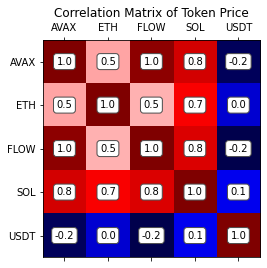

In [15]:
return_data_price = df_log_return[df_log_return.columns[0:5]].corr()

fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(return_data_price, cmap='seismic')

for (i, j), z in np.ndenumerate(return_data_price):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

xaxis = np.arange(5)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(df_log_return.columns[0:5])
ax.set_yticklabels(df_log_return.columns[0:5])

ax.set_title("Correlation Matrix of Token Price")

plt.show()

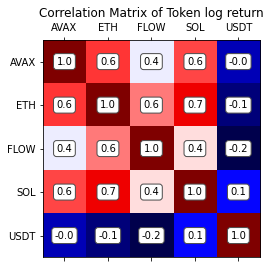

In [16]:
return_data_returns = df_log_return[df_log_return.columns[5:10]].corr()

fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(return_data_returns, cmap='seismic')

for (i, j), z in np.ndenumerate(return_data_returns):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

xaxis = np.arange(5)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(df_log_return.columns[0:5])
ax.set_yticklabels(df_log_return.columns[0:5])

ax.set_title("Correlation Matrix of Token log return")

plt.show()